In [1]:

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import metrics

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [3]:
# AGCE Loss
class AGCELoss(nn.Module):
    def __init__(self, num_classes=10, a=1, q=2, scale=1.):
        super(AGCELoss, self).__init__()
        self.a = a
        self.q = q
        self.num_classes = num_classes
        self.scale = scale

    def forward(self, pred, labels):
        pred = F.softmax(pred, dim=1)
        label_one_hot = F.one_hot(labels, self.num_classes).float().to(pred.device)
        loss = ((self.a+1)**self.q - torch.pow(self.a + torch.sum(label_one_hot * pred, dim=1), self.q)) / self.q
        return loss.mean() * self.scale

In [4]:
# Define the CNN model
class MNISTModel(nn.Module):
    def __init__(self):
        super(MNISTModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=0)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=0)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(64 * 5 * 5, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.flatten(x)
        x = self.dropout(x)
        x = self.fc(x)
        return x


In [5]:


# Load MNIST data
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Extract data and labels
x_train = train_dataset.data.numpy().astype('float32') / 255.0
y_train = train_dataset.targets.numpy()
x_test = test_dataset.data.numpy().astype('float32') / 255.0
y_test = test_dataset.targets.numpy()

# Reshape data
x_train = x_train.reshape(-1, 1, 28, 28)
x_test = x_test.reshape(-1, 1, 28, 28)

# Add noisy labels
NOISE_LEVEL = 0.4
perm = np.array([7, 9, 0, 4, 2, 1, 3, 5, 6, 8])
noise = perm[y_train]

if NOISE_LEVEL > 0:
    _, noise_idx = next(iter(StratifiedShuffleSplit(n_splits=1,
                                                    test_size=NOISE_LEVEL,
                                                    random_state=42).split(x_train, y_train)))
    y_train_noise = y_train.copy()
    y_train_noise[noise_idx] = noise[noise_idx]

    train_idx, val_idx = next(iter(
        StratifiedShuffleSplit(n_splits=1, test_size=0.1,
                              random_state=42).split(x_train, y_train_noise)))

    X_train_train = x_train[train_idx]
    y_train_correct = y_train[train_idx]
    y_train_train = y_train_noise[train_idx]
    X_train_val = x_train[val_idx]
    y_train_val = y_train_noise[val_idx]
    y_train_val_correct = y_train[val_idx]
else:
    train_idx, val_idx = next(iter(
        StratifiedShuffleSplit(n_splits=1, test_size=0.1,
                              random_state=42).split(x_train, y_train)))
    X_train_train = x_train[train_idx]
    y_train_train = y_train[train_idx]
    y_train_correct = y_train[train_idx]
    X_train_val = x_train[val_idx]
    y_train_val = y_train[val_idx]
    y_train_val_correct = y_train[val_idx]

# Convert to PyTorch tensors
X_train_train = torch.FloatTensor(X_train_train)
y_train_train = torch.LongTensor(y_train_train)
X_train_val = torch.FloatTensor(X_train_val)
y_train_val_correct = torch.LongTensor(y_train_val_correct)
x_test = torch.FloatTensor(x_test)
y_test = torch.LongTensor(y_test)

# Create DataLoaders
train_dataset = TensorDataset(X_train_train, y_train_train)
val_dataset = TensorDataset(X_train_val, y_train_val_correct)
test_dataset = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.00MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 132kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.23MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.7MB/s]


In [6]:

# Initialize model
model = MNISTModel().to(device)
optimizer = optim.Adam(model.parameters())

In [7]:

# Use AGCE loss (a=1, q=2 for robust noise tolerance on MNIST)
criterion = AGCELoss(num_classes=10, a=1, q=2, scale=1.)

In [8]:

# Training function
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    return running_loss / len(loader), correct / total


# Validation function
def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    return running_loss / len(loader), correct / total



In [9]:

# Training loop with early stopping
epochs = 10
patience = 4
best_val_loss = float('inf')
patience_counter = 0

history = {
    'loss': [],
    'accuracy': [],
    'val_loss': [],
    'val_accuracy': []
}

for epoch in range(epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    history['loss'].append(train_loss)
    history['accuracy'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_acc)

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model_agce.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered after epoch {epoch+1}")
            break

# Load best model
model.load_state_dict(torch.load('best_model_agce.pth'))

# Evaluate on test set
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(targets.numpy())

y_pred = np.array(y_pred)
y_true = np.array(y_true)

acc = metrics.accuracy_score(y_true, y_pred)
macro_averaged_f1 = metrics.f1_score(y_true, y_pred, average='macro')
print(f"\nTest Accuracy: {acc:.4f}")
print(f"Test Macro F1: {macro_averaged_f1:.4f}")



Epoch 1/10
Train Loss: 1.0070, Train Acc: 0.3572
Val Loss: 0.6421, Val Acc: 0.5803
Epoch 2/10
Train Loss: 0.8656, Train Acc: 0.4290
Val Loss: 0.6288, Val Acc: 0.5862
Epoch 3/10
Train Loss: 0.8334, Train Acc: 0.4501
Val Loss: 0.6184, Val Acc: 0.5920
Epoch 4/10
Train Loss: 0.8181, Train Acc: 0.4591
Val Loss: 0.6139, Val Acc: 0.5943
Epoch 5/10
Train Loss: 0.8108, Train Acc: 0.4633
Val Loss: 0.6083, Val Acc: 0.5967
Epoch 6/10
Train Loss: 0.8073, Train Acc: 0.4650
Val Loss: 0.6076, Val Acc: 0.5972
Epoch 7/10
Train Loss: 0.7413, Train Acc: 0.5109
Val Loss: 0.4712, Val Acc: 0.6885
Epoch 8/10
Train Loss: 0.7264, Train Acc: 0.5192
Val Loss: 0.4752, Val Acc: 0.6852
Epoch 9/10
Train Loss: 0.7204, Train Acc: 0.5228
Val Loss: 0.4660, Val Acc: 0.6912
Epoch 10/10
Train Loss: 0.7177, Train Acc: 0.5241
Val Loss: 0.4658, Val Acc: 0.6908

Test Accuracy: 0.6923
Test Macro F1: 0.5894


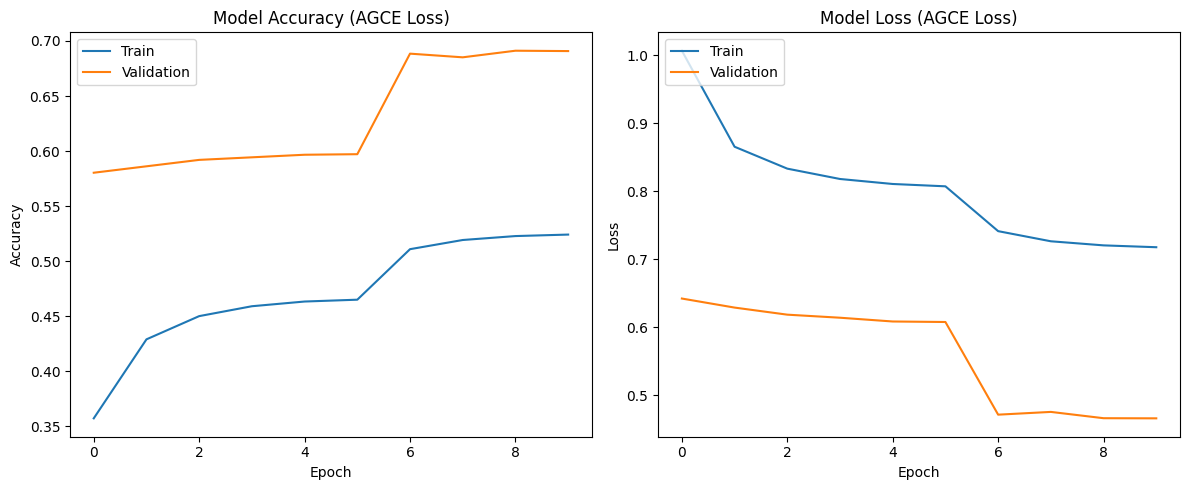


Noise Level: 0.4
Loss Function: AGCE (a=1, q=2)


In [10]:

# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model Accuracy (AGCE Loss)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model Loss (AGCE Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.savefig('training_history_agce.png')
plt.show()

print(f"\nNoise Level: {NOISE_LEVEL}")
print(f"Loss Function: AGCE (a=1, q=2)")
